# **`flygym`-MuJoCo tutorial:** Replay of recorded behavior

<a target="_blank" href="https://colab.research.google.com/github/NeLy-EPFL/flygym/blob/main/notebooks/mujoco_replay.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

**NOTE: You need to select a GPU instance on Google Colab for this notebook. Go to "Runtime" > "Change runtime type", select "GPU" under "Hardware accelerator" and click "Save."**

See [GitHub repo](https://github.com/NeLy-EPFL/flygym) for code and [documentation here](https://nely-epfl.github.io/flygym/).

In particular, you're encouraged to read the following pages on the documentation before proceeding with this tutorial:
- [The NeuroMechFly Model](https://nely-epfl.github.io/flygym/neuromechfly.html)
- [Interacting with an Environment](https://nely-epfl.github.io/flygym/environments/index.html)
- [The former demo on basic control](https://colab.research.google.com/github/NeLy-EPFL/flygym/blob/main/notebooks/mujoco_sinewave.ipynb)

In [1]:
"""#@title Install `flygym` on Colab

# This block is modified from dm_control's tutorial notebook
# https://github.com/deepmind/dm_control/blob/main/tutorial.ipynb

import subprocess
if subprocess.run('nvidia-smi').returncode:
    raise RuntimeError(
        'Cannot communicate with GPU. '
        'Make sure you are using a GPU Colab runtime. '
        'Go to the Runtime menu and select Choose runtime type.')

print('Installing flygym')
!pip install -q --progress-bar=off 'flygym[mujoco] @ git+https://github.com/NeLy-EPFL/flygym.git@decentralized_ctrl'

# Configure dm_control to use the EGL rendering backend (requires GPU)
%env MUJOCO_GL=egl

print('Checking that the dm_control installation succeeded...')
try:
    from dm_control import suite
    env = suite.load('cartpole', 'swingup')
    pixels = env.physics.render()
except Exception as e:
    raise e from RuntimeError(
        'Something went wrong during dm_control installation. Check the shell '
        'output above for more information.\n'
        'If using a hosted Colab runtime, make sure you enable GPU acceleration '
        'by going to the Runtime menu and selecting "Choose runtime type".')
else:
    del pixels, suite

print('Checking that the flygym installation succeeded...')
try:
    import flygym
    from flygym import envs
except Exception as e:
    raise e from RuntimeError(
        'Something went wrong during flygym installation. Check the shell '
        'output above for more information.\n')
else:
    del envs, flygym """

'#@title Install `flygym` on Colab\n\n# This block is modified from dm_control\'s tutorial notebook\n# https://github.com/deepmind/dm_control/blob/main/tutorial.ipynb\n\nimport subprocess\nif subprocess.run(\'nvidia-smi\').returncode:\n    raise RuntimeError(\n        \'Cannot communicate with GPU. \'\n        \'Make sure you are using a GPU Colab runtime. \'\n        \'Go to the Runtime menu and select Choose runtime type.\')\n\nprint(\'Installing flygym\')\n!pip install -q --progress-bar=off \'flygym[mujoco] @ git+https://github.com/NeLy-EPFL/flygym.git@decentralized_ctrl\'\n\n# Configure dm_control to use the EGL rendering backend (requires GPU)\n%env MUJOCO_GL=egl\n\nprint(\'Checking that the dm_control installation succeeded...\')\ntry:\n    from dm_control import suite\n    env = suite.load(\'cartpole\', \'swingup\')\n    pixels = env.physics.render()\nexcept Exception as e:\n    raise e from RuntimeError(\n        \'Something went wrong during dm_control installation. Check the 

In [2]:
import numpy as np
import pkg_resources
import pickle
import matplotlib.pyplot as plt
from pathlib import Path
from flygym.envs.nmf_mujoco import NeuroMechFlyMuJoCo
from tqdm import trange
from flygym.util.config import leg_dofs_fused_tarsi

from scipy.signal import medfilt

import PIL.Image

---

This notebook demonstrates another simple controller based on decentralized control.

Few rules based on the observation on stick insects by [Cruse et al.](https://moodle.epfl.ch/pluginfile.php/2323895/course/section/241288/cruse-insect_walking.pdf) are enough to coordinate stepping and generate locomotion.

The rules proposed by Cruse et al. are:
1) Suppress lift-off to avoid static instability.
2) Facilitate early protraction to favour temporal coherence.
3) Enforce late protraction to maintain temporal coherence.
4) Aim touchdown location to exploit prior ‘knowledge’ about foothold.
5) Distribute propulsive force among the legs to share load efficiently.
6) Enforce a correction step to avoid stumbling due to leg placement errors.

In this notebook we will explore how rules 1, 2 and 3 are sufficient to generate locomotion on flat terrain. The additional rules are powerfull on complex terrain. 

Each leg influences a set of legs through those rules. The sheme of coupling is defined in <img src="https://github.com/NeLy-EPFL/flygym/blob/decentralized_ctrl/doc/source/_static/cruse_rules.png" alt="CruseRules" width="1000"> <figcaption>Source: M.Shilling, H.Cruse https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1009362</figcaption>

Similar to the previous demos, we start by initializing the simulation environment:

In [3]:
# Initialize simulation
run_time = 1
out_dir = Path('../decentralized_ctrl')

friction = 1.0

physics_config = {
    'joint_stiffness': 2500,
    'friction': (friction, 0.005, 0.0001),
    'gravity': (0, 0, -9.81e5)}
terrain_config = {'fly_pos': (0, 0, 300),
                  'friction': (friction, 0.005, 0.0001)}

nmf = NeuroMechFlyMuJoCo(render_mode='saved',
                         timestep=1e-4,
                         render_config={'playspeed': 0.1, "camera":"Animat/camera_left_top"},
                         init_pose='stretch',
                         actuated_joints=leg_dofs_fused_tarsi)

We then load the data generating single step in each leg

In [4]:
# Load recorded data
data_path = Path(pkg_resources.resource_filename('flygym', 'data'))
with open(data_path / 'engineered' / 'single_steps.pkl', 'rb') as f:
    data = pickle.load(f)

The data is in the form of a dictionary. Each key is a joint degree of freedom (Dof). The corresponding value is a time series of that DoF to generate a single step cycle (swing followed by stance). Additionally, there's a key `'meta'` that maps to some metadata of the recording:

In [5]:
print('Dict keys:', data.keys())
print('Length of time series:', data['joint_RFCoxa'])
print('Metadata:', data['meta'])

Dict keys: dict_keys(['meta', 'joint_LFCoxa', 'joint_LFCoxa_roll', 'joint_LFCoxa_yaw', 'joint_LFFemur', 'joint_LFFemur_roll', 'joint_LFTibia', 'joint_LFTarsus1', 'joint_LMCoxa', 'joint_LMCoxa_roll', 'joint_LMCoxa_yaw', 'joint_LMFemur', 'joint_LMFemur_roll', 'joint_LMTibia', 'joint_LMTarsus1', 'joint_LHCoxa', 'joint_LHCoxa_roll', 'joint_LHCoxa_yaw', 'joint_LHFemur', 'joint_LHFemur_roll', 'joint_LHTibia', 'joint_LHTarsus1', 'joint_RFCoxa', 'joint_RFCoxa_roll', 'joint_RFCoxa_yaw', 'joint_RFFemur', 'joint_RFFemur_roll', 'joint_RFTibia', 'joint_RFTarsus1', 'joint_RMCoxa', 'joint_RMCoxa_roll', 'joint_RMCoxa_yaw', 'joint_RMFemur', 'joint_RMFemur_roll', 'joint_RMTibia', 'joint_RMTarsus1', 'joint_RHCoxa', 'joint_RHCoxa_roll', 'joint_RHCoxa_yaw', 'joint_RHFemur', 'joint_RHFemur_roll', 'joint_RHTibia', 'joint_RHTarsus1'])
Length of time series: [0.61922731 0.61871353 0.61819975 ... 0.63212368 0.6256755  0.61922731]
Metadata: {'timestep': 0.0001, 'source': 'Analyze_step_data.ipynb'}


Notice that the metadata shows that the kinematic tracking time series is 1-second long (from t=3 to t=4 in some recording file), and that temporal resolution is 0.0005 seconds per step. Our simulation (as defined above) runs at a timestep of 0.0001s. This is 5 times faster. Therefore, we need to interpolate our recording.

In general, we want to use a very small time step in the physics simulation. Camera recordings and 3D pose instructions are often way coarser. Therefore, interpolation is often mandatory.

We further put the data into a NumPy array of shape (num_joints, num_steps). This way, at the i-th time step, we can simply take i-th column of the array as our joint control signals:

In [6]:
# Interpolate 5x
num_steps_base = int(run_time / nmf.timestep)
step_duration = len(data['joint_LFCoxa'])
interp_step_duration = int(step_duration * data['meta']['timestep'] / nmf.timestep)
step_data_block_base = np.zeros((len(nmf.actuated_joints), interp_step_duration))
measure_t = np.arange(step_duration) * data['meta']['timestep']
interp_t = np.arange(interp_step_duration) * nmf.timestep
for i, joint in enumerate(nmf.actuated_joints):
    step_data_block_base[i, :] = np.interp(interp_t, measure_t, data[joint])

In [7]:
run_time, num_steps_base, nmf.timestep, interp_step_duration, step_duration, 0.5/nmf.timestep

(1, 10000, 0.0001, 1278, 1278, 5000.0)

Let's visualze some recorded joint single step time series. The joint angles leading to step in each leg has been extracted from ball locomotion data. Uppon replay of the kinematic, steps with the highest z elevation that led toa swing stance cycle were collected for each Front, Middle and Hind leg. This data is probably dependant on the exact ballance of the fly at the tine were the step was performed. Keep in mind that there are probably many ways to construct a better step data by either manually engineering them with fewer degrees of freedom or replaying kinematic data for one step at a time and extracting the best step when the fly is balanced. Decentralized control could be couled with reinforcement learning were initiation of the step is controlled with decentralized control and exact trajectory of the step would be executed by the trained networks. 

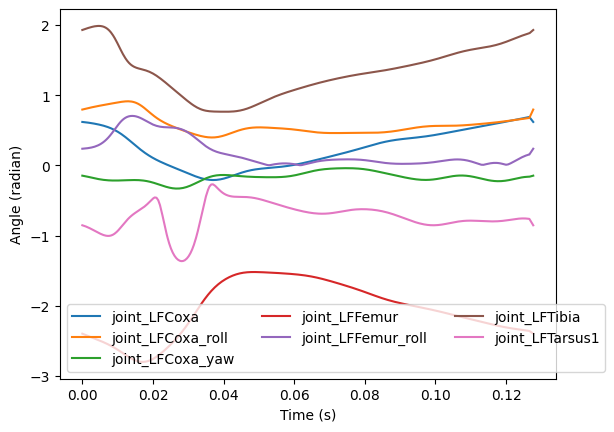

In [8]:
num_joints_to_visualize = 7
plt.plot(np.arange(step_data_block_base.shape[1]) * nmf.timestep,
         step_data_block_base[:num_joints_to_visualize].T,
         label=nmf.actuated_joints[:num_joints_to_visualize])
plt.legend(ncol = 3)
plt.xlabel('Time (s)')
plt.ylabel('Angle (radian)')
plt.show()

# Fine tuning of the stepping data

As explained before the step data was extracted from ball locomotion data. We are going to manually modify joint angles so that the load is evenly distributed in the resting pose and the fly stance looks realitic.

### Base pose from ball data

All legs should be touching the ground in the starting pose of each step

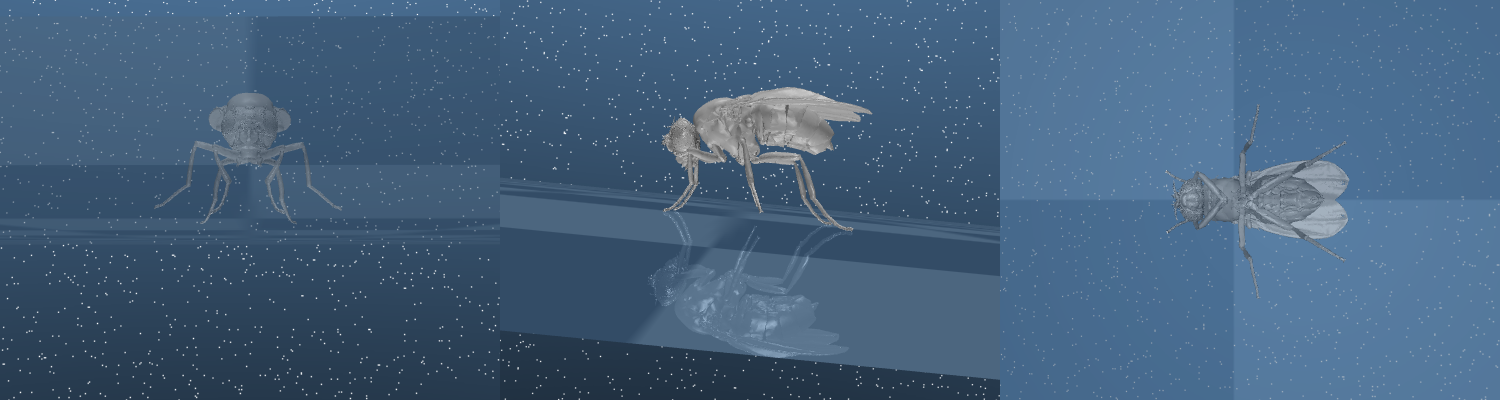

In [9]:
"""nmf = NeuroMechFlyMuJoCo(render_mode='saved',
                         #terrain = "gapped",
                         output_dir=out_dir,
                         timestep=1e-4,
                         render_config={'playspeed': 0.1, "camera":"Animat/camera_left"},
                         init_pose='stretch',
                         actuated_joints=leg_dofs_fused_tarsi,
                         physics_config=physics_config,
                         terrain_config=terrain_config)"""


n_timesteps = 1000
for i in range(n_timesteps):
    action = {'joints': step_data_block_base[:, 0]}
    _, _ = nmf.step(action)

all_viewpoints = []
h, w = 400, 500
for viewpoint in ['camera_front', 'camera_left', 'camera_bottom']:
    all_viewpoints.append(nmf.physics.render(camera_id=f"Animat/{viewpoint}", width=w, height=h))


im = PIL.Image.fromarray(np.hstack(all_viewpoints))
#show image
display(im)

### Manually restoring the balance

The result we obtain is nowhere near the natural stance of a fly. From experience we can make a few observations:
- The fly is tilted forward. On flat terrain the fly has a more balanced stance or tends to lean slightly backward.
- The fly's middle leg are not touching the floor-
- The hindleg's Tarsus should be more parallel to the floor


To allievate those issues, we will modify the joint angles. We will:
1) Protract the midlegs
2) Make the Tarsus more parallel to the floor
3) Retract the hindlegs

Finally we should try to balance the contact forces across the 6 legs of the fly.

In [10]:
step_data_block_manualcorrect = step_data_block_base.copy()

for side in ["L", "R"]:
    step_data_block_manualcorrect[nmf.actuated_joints.index(f"joint_{side}MCoxa")] += np.deg2rad(13) # Protract the midlegs
    
    #step_data_block_manualcorrect[nmf.actuated_joints.index(f"joint_{side}HCoxa")] -= np.deg2rad(0)
    step_data_block_manualcorrect[nmf.actuated_joints.index(f"joint_{side}HFemur")] += np.deg2rad(-5) # Retract the hindlegs
    #step_data_block_manualcorrect[nmf.actuated_joints.index(f"joint_{side}HTibia")] += np.deg2rad(0)
    step_data_block_manualcorrect[nmf.actuated_joints.index(f"joint_{side}HTarsus1")] -= np.deg2rad(15) # Tarsus more parallel to the ground (flexed) (also helps with the hindleg retraction)
    #step_data_block_manualcorrect[nmf.actuated_joints.index(f"joint_{side}FTibia")] += np.deg2rad(0)
    step_data_block_manualcorrect[nmf.actuated_joints.index(f"joint_{side}FFemur")] += np.deg2rad(15) # Protract the forelegs (slightly to conterbalance Tarsus flexion)
    step_data_block_manualcorrect[nmf.actuated_joints.index(f"joint_{side}FTarsus1")] -= np.deg2rad(15) # Tarsus more parallel to the ground (flexed) (add some retraction of the forelegs)

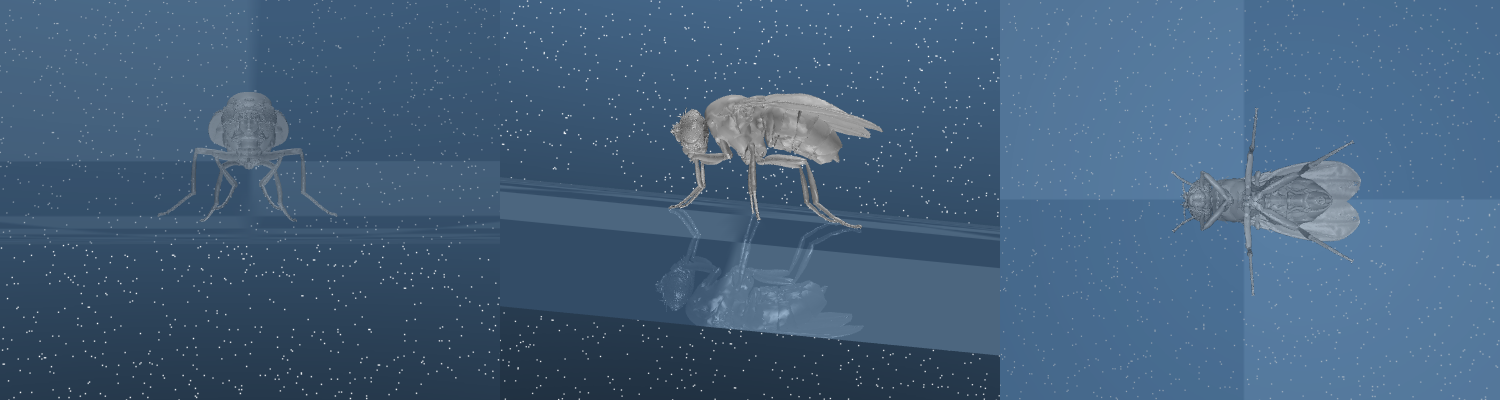

In [11]:
nmf.reset()
"""nmf = NeuroMechFlyMuJoCo(render_mode='saved',
                         output_dir=out_dir,
                         timestep=1e-4,
                         render_config={'playspeed': 0.1, "camera":"Animat/camera_left_top"},
                         init_pose='stretch',
                         actuated_joints=leg_dofs_fused_tarsi,
                         terrain_config=terrain_config,
                         physics_config=physics_config)
"""

action = {'joints': step_data_block_manualcorrect[:, 0]}
obs, _ = nmf.step(action)
i = 0
legs = ["RF", "LF", "RH", "LH", "RM", "LM"]
all_tarsus5_pos = {l:[] for l in legs}


# Run until the fly sped is less than 50 micron/sec or 50000 steps
while np.sum(np.abs(obs["fly"][1])) > 50 and i < 50000:
    action = {'joints': step_data_block_manualcorrect[:, 0]}
    obs, _ = nmf.step(action)
    i += 1
    nmf.render()
   
# Keep track of the time it takes to stabilize
n_steps_stabil = i

nmf.save_video(out_dir / "video_initial_stance.mp4")
"""nmf.close()"""
all_viewpoints = []
h, w = 400, 500
for viewpoint in ['camera_front', 'camera_left', 'camera_bottom']:
    all_viewpoints.append(nmf.physics.render(camera_id=f"Animat/{viewpoint}", width=w, height=h))

im = PIL.Image.fromarray(np.hstack(all_viewpoints))
#show image
display(im)

In [12]:
from ipywidgets import Video
Video.from_file(out_dir / 'video_initial_stance.mp4')

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free...')

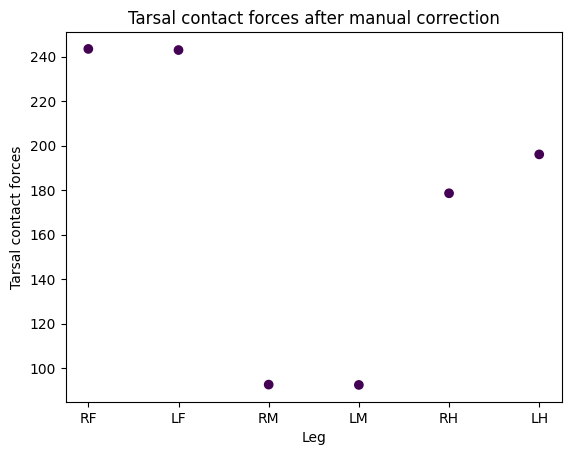

In [13]:
# Check load distribution from manual correction

legs = ["RF", "LF", "RM", "LM", "RH", "LH"]
leg_force_sensors_ids = {leg:[] for leg in legs}
for i, collision_geom in enumerate(nmf.collision_tracked_geoms):
    for leg in legs:
        if collision_geom.startswith(leg+"Tarsus"):
            leg_force_sensors_ids[leg].append(i)   

contact_forces = np.array([np.sum(obs["contact_forces"][leg_force_sensors_ids[leg]]) for leg in legs])
color = contact_forces <= 0
plt.scatter(np.arange(len(legs)), contact_forces, c=color)
plt.xticks(np.arange(len(legs)), legs)
plt.xlabel("Leg")
plt.ylabel("Tarsal contact forces")
plt.title("Tarsal contact forces after manual correction")
plt.show()

### Evaluate the step

Now that we have improved the resting pose of the fly, lets evaluate the step generated by the manually corrected joint angles.

In [14]:
nmf.reset()
"""nmf = NeuroMechFlyMuJoCo(render_mode='saved',
                         output_dir=out_dir,
                         timestep=1e-4,
                         render_config={'playspeed': 0.1, "camera":"Animat/camera_left"},
                         init_pose='stretch',
                         actuated_joints=leg_dofs_fused_tarsi,
                         terrain_config=terrain_config,
                         physics_config=physics_config)"""


legs = ["RH", "LH", "RF", "LF", "RM", "LM"]
leg_ids = np.arange(len(legs)).astype(int)
leg_corresp_id = dict(zip(legs, leg_ids))
n_joints = len(nmf.actuated_joints)
joint_ids = np.arange(n_joints).astype(int)
match_leg_to_joints = np.array([i  for joint in nmf.actuated_joints for i, leg in enumerate(legs) if leg in joint])

n_rest_timesteps = 2000

leg_force_sensors_ids = {leg:[] for leg in legs}
for i, collision_geom in enumerate(nmf.collision_tracked_geoms):
    for leg in legs:
        if collision_geom.startswith(leg+"Tarsus"):
            leg_force_sensors_ids[leg].append(i)   

touch_sensor_data = np.zeros((len(legs), interp_step_duration+n_rest_timesteps-1))

# Get the position of the last segment of the tarsus for each leg in the 
leg_tarsi_pos_id = {leg:[i] for leg in legs for i, joint in enumerate(nmf.actuated_joints) if leg in joint and "Tarsus1" in joint}
position_data = np.zeros((len(legs), interp_step_duration+n_rest_timesteps-1, 3))

for k in range(n_steps_stabil):
        action = {'joints': step_data_block_manualcorrect[joint_ids, 0]}
        obs, info = nmf.step(action)
        nmf.render()

# Lets step each leg on after the other collect touch sensor data as well as 3d coordinates of the last segment of the tarsus
for i, leg in enumerate(legs):
    
    joints_to_actuate = np.zeros(len(nmf.actuated_joints)).astype(int)
    joints_to_actuate[match_leg_to_joints == i] = 1
    
    for k in range(interp_step_duration):
        joint_pos = step_data_block_manualcorrect[joint_ids, joints_to_actuate*k]
        action = {'joints': joint_pos}
        obs, info = nmf.step(action)
        touch_sensor_data[i, k] = np.sum(obs['contact_forces'][leg_force_sensors_ids[leg]])
        position_data[i, k, :] = np.squeeze(nmf.physics.named.data.xpos[f"Animat/{leg}Tarsus5"]) #Get the position data from physics

        nmf.render()

    for j in range(n_rest_timesteps):
        action = {'joints': step_data_block_manualcorrect[joint_ids, 0]}
        obs, info = nmf.step(action)
        touch_sensor_data[i, k+j] = np.sum(obs['contact_forces'][leg_force_sensors_ids[leg]])
        position_data[i, k+j, :] = np.squeeze(nmf.physics.named.data.xpos[f"Animat/{leg}Tarsus5"]) #Get the position data from physics
        nmf.render()

nmf.save_video(out_dir / "video_steps.mp4")

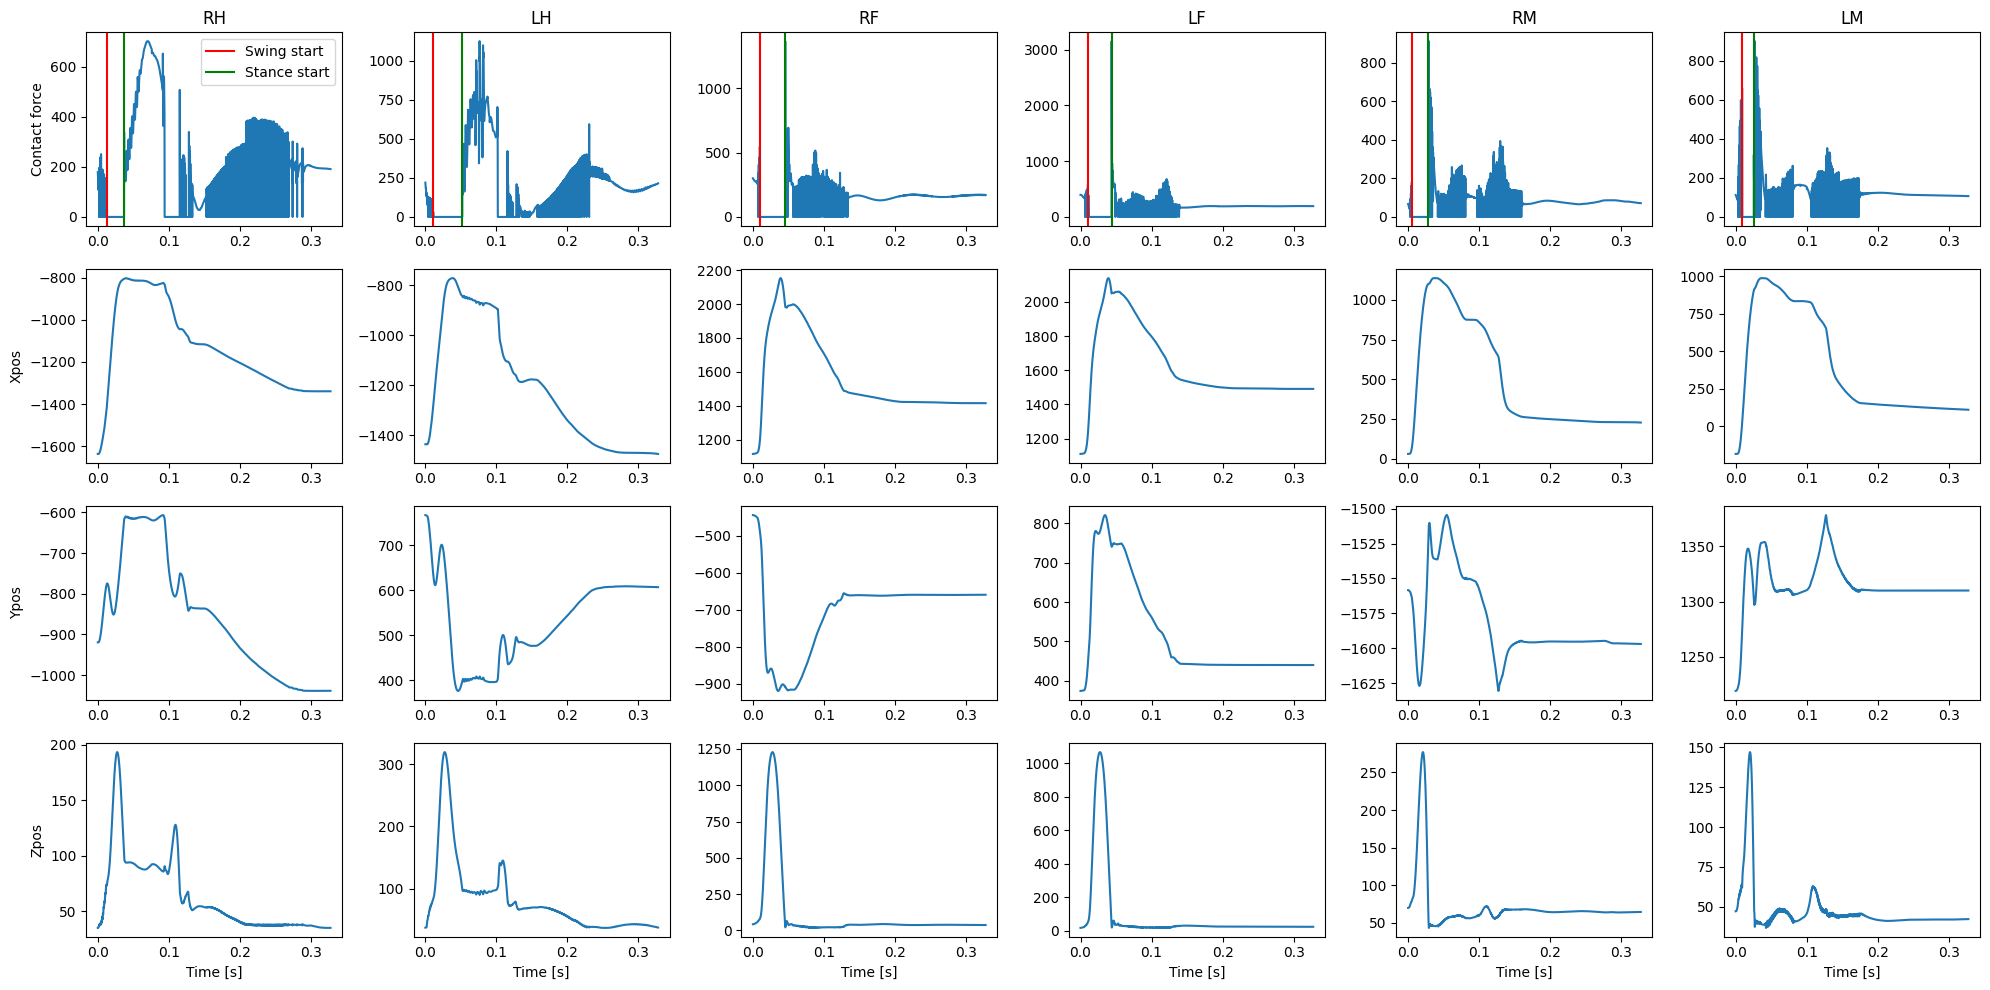

In [15]:
fig, axs = plt.subplots(4, len(legs), figsize=(20, 10))
t = np.arange(touch_sensor_data.shape[1])*nmf.timestep

leg_swing_starts = {}
leg_stance_starts = {}

stride = 20 # Number of timesteps to check for contact
eps = 10 # Threshold for detecting contact

for i, leg in enumerate(legs):
    # Plot contact forces
    axs[0, i].plot(t, touch_sensor_data[i, :])
    k = 0
    # Until you find a swing onset keep going (as long as k is less than the length of the data)
    while k < len(touch_sensor_data[i]) and not np.all(touch_sensor_data[i, k:k+stride] == 0):
        k += 1
    swing_start = k
    if k < len(touch_sensor_data[i]):
        # Find the first time the contact force is above the threshold
        stance_start = np.where(touch_sensor_data[i, swing_start:] > eps)[0][0] + swing_start
        axs[0, i].axvline(t[swing_start], color='r', label="Swing start")
        axs[0, i].axvline(t[stance_start], color='g', label="Stance start")
        if i == 0:
            axs[0, i].legend()
        leg_swing_starts[leg] = swing_start
        leg_stance_starts[leg] = stance_start
    else:
        leg_swing_starts[leg] = 0
        leg_stance_starts[leg] = 0
        
    # Plot 3d coordinates of the last segment of the tarsus
    axs[1, i].plot(t, position_data[i, :, 0])
    axs[2, i].plot(t, position_data[i, :, 1])
    axs[3, i].plot(t, position_data[i, :, 2])
    axs[0, i].set_title(leg)
    if i == 0:
        axs[0, i].set_ylabel('Contact force')
        axs[1, i].set_ylabel('Xpos')
        axs[2, i].set_ylabel('Ypos')
        axs[3, i].set_ylabel('Zpos')
for j in range(len(legs)):
    axs[-1, j].set_xlabel('Time [s]')    

plt.tight_layout()

In [16]:
from ipywidgets import Video
Video.from_file(out_dir / 'video_steps.mp4')

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free...')

In [17]:
# Save the data and the step_timing


# Approach based on timing 

## Define helper variables

Lets represent the rules influences in a dictionnary. We might want to iterate through leg ids and might need some other dictionnaries to go from name to id representation. 

We are going to implement the Cruse rule by computing the step score of each leg for each simulation timestep. Step will be initiated in the legs having the highest score. If scores are close (within 0.1% of the max score) we choose randomly between the legs

In [18]:
# Initialize simulation
n_stabilisation_steps = n_steps_stabil
# Run the simulation for a few steps to stabilise the system before starting the contoller
num_steps = num_steps_base + n_stabilisation_steps

#Define rule variables
legs = ["RF", "LF", "RM", "LM", "RH", "LH"]
leg_ids = np.arange(len(legs)).astype(int)
leg_corresp_id = dict(zip(legs, leg_ids))
n_joints = len(nmf.actuated_joints)
joint_ids = np.arange(n_joints).astype(int)
match_leg_to_joints = np.array([i  for joint in nmf.actuated_joints for i, leg in enumerate(legs) if leg in joint])

# This serves to keep track of the advancement of each leg in the stepping sequence
stepping_advancement = np.zeros(len(legs)).astype(int)
rule1_corresponding_legs = {"LH":["LM"], "LM":["LF"], "LF":[], "RH":["RM"], "RM":["RF"], "RF":[]}
rule2_corresponding_legs = {"LH":["LM", "RH"], "LM":["LF", "RM"], "LF":["RF"], "RH":["RM", "LH"], "RM":["RF", "LM"], "RF":["LF"]}
rule3_corresponding_legs = {"LH":["RH"], "LM":["LH", "RM"], "LF":["LM", "RF"], "RH":["LH"], "RM":["RH", "LM"], "RF":["LF", "RM"]}

#Rule 1 should supress lift off (if a leg is in swing coupled legs should not be lifted most important leg to guarantee stability)
rule1_weight = -1e4
#Rule 2 should facilitate early protraction (upon touchdown of a leg coupled legs are encouraged to swing)
rule2_weight = 2.5
rule2_weight_contralateral = 1
#Rule 3 should enforce late protraction (the later in the stance the more it facilitates stance initiation)
rule3_weight = 3
rule3_weight_contralateral = 2

# This represents the score of each leg in the current step
leg_scores = np.zeros(len(legs))
all_leg_scores = np.zeros((len(legs), num_steps))

# Monitor the evolution of each part of the score for each leg
all_legs_rule1_scores = np.zeros((len(legs), num_steps))
all_legs_rule2_scores = np.zeros((len(legs), num_steps))
all_legs_rule3_scores = np.zeros((len(legs), num_steps))

# one percent margin if leg score within this margin to the max score random choice between the very likely legs
percent_margin = 0.001

# For each leg the ids of the force sensors that are attached to it
leg_force_sensors_ids = {leg:[] for leg in legs}
for i, collision_geom in enumerate(nmf.collision_tracked_geoms):
    for leg in legs:
        if collision_geom.startswith(leg):
            leg_force_sensors_ids[leg].append(i)   

## Define helper functions

In [19]:
def update_stepping_advancement(stepping_advancement, legs, interp_step_duration):
    for k, leg in enumerate(legs):
        if stepping_advancement[k] >= interp_step_duration-1:
            stepping_advancement[k] = 0
        elif stepping_advancement[k] > 0:
            stepping_advancement[k] +=1
    return stepping_advancement

def compute_leg_scores(rule1_corresponding_legs, rule1_weight,
                       rule2_corresponding_legs, rule2_weight, rule2_weight_contralateral,
                       rule3_corresponding_legs, rule3_weight, rule3_weight_contralateral,
                       stepping_advancement, leg_corresp_id, leg_stance_starts, interp_step_duration):
    leg_scores = np.zeros(len(legs))
    
    #Iterate through legs to compute score
    for k, leg in enumerate(legs):        
        # For the first rule
        leg_scores[[leg_corresp_id[l] for l in rule1_corresponding_legs[leg]]] += rule1_weight*(stepping_advancement[k]>0 and stepping_advancement[k]<leg_stance_starts[leg]).astype(float)
        all_legs_rule1_scores[[leg_corresp_id[l] for l in rule1_corresponding_legs[leg]], i] += rule1_weight*(stepping_advancement[k]>0 and stepping_advancement[k]<leg_stance_starts[leg]).astype(float)       
        
        #For the second rule strong contact force happens at the beggining of the stance phase
        for l in rule2_corresponding_legs[leg]:
            if l[0] == leg[0]:
                #ipsilateral leg
                leg_scores[leg_corresp_id[l]] += rule2_weight*((interp_step_duration - leg_stance_starts[leg])-(stepping_advancement[k] - leg_stance_starts[leg])) if (stepping_advancement[k] - leg_stance_starts[leg])>0 else 0
                all_legs_rule2_scores[leg_corresp_id[l], i] += rule2_weight*((interp_step_duration - leg_stance_starts[leg])-(stepping_advancement[k] - leg_stance_starts[leg])) if (stepping_advancement[k] - leg_stance_starts[leg])>0 else 0
            else:
                #contralateral leg
                leg_scores[leg_corresp_id[l]] += rule2_weight_contralateral*((interp_step_duration - leg_stance_starts[leg])-(stepping_advancement[k] - leg_stance_starts[leg])) if (stepping_advancement[k] - leg_stance_starts[leg])>0 else 0
                all_legs_rule2_scores[leg_corresp_id[l], i] += rule2_weight_contralateral*((interp_step_duration - leg_stance_starts[leg])-(stepping_advancement[k] - leg_stance_starts[leg])) if (stepping_advancement[k] - leg_stance_starts[leg])>0 else 0

        #For the third rule
        for l in rule3_corresponding_legs[leg]:
            if l[0] == leg[0]:
                leg_scores[leg_corresp_id[l]] += rule3_weight*((stepping_advancement[k] - leg_stance_starts[leg])) if (stepping_advancement[k] - leg_stance_starts[leg])>0 else 0
                all_legs_rule3_scores[leg_corresp_id[l], i] += rule3_weight*((stepping_advancement[k] - leg_stance_starts[leg])) if (stepping_advancement[k] - leg_stance_starts[leg])>0 else 0
            else:
                leg_scores[leg_corresp_id[l]] += rule3_weight_contralateral*((stepping_advancement[k] - leg_stance_starts[leg])) if (stepping_advancement[k] - leg_stance_starts[leg])>0 else 0
                all_legs_rule3_scores[leg_corresp_id[l], i] += rule3_weight_contralateral*((stepping_advancement[k] - leg_stance_starts[leg])) if (stepping_advancement[k] - leg_stance_starts[leg])>0 else 0

    return leg_scores

## Run the simulation

In [20]:
np.random.seed(42)

"""nmf = NeuroMechFlyMuJoCo(render_mode='saved',
                         output_dir=out_dir,
                         timestep=1e-4,
                         render_config={'playspeed': 0.1, 'camera':"Animat/camera_left"},
                         init_pose='stretch',
                         actuated_joints=leg_dofs_fused_tarsi,
                         physics_config=physics_config,
                         terrain_config=terrain_config)"""
nmf.reset()

# Track the number of steps taken. It will be used to determine the stpping probability in the random stepper
number_of_taken_steps = 0

obs_list_cruse_flat = []
all_initiated_legs = []

#Run the actual simulation
for i in trange(num_steps):

    #Decide in which leg to step
    initiating_leg = np.argmax(leg_scores)
    within_margin_legs = leg_scores[initiating_leg]-leg_scores <= leg_scores[initiating_leg]*percent_margin

    # If multiple legs are within the margin choose randomly among those legs
    if np.sum(within_margin_legs) > 1:
        initiating_leg = np.random.choice(np.where(within_margin_legs)[0])

    # If the maximal score is zero or less (except for the first step after stabilisation to initate the locomotion) or if the leg is already stepping
    if (leg_scores[initiating_leg] <= 0 and not i == n_stabilisation_steps+1) or stepping_advancement[initiating_leg] > 0:
        initiating_leg = None
    else:
        stepping_advancement[initiating_leg] += 1
        all_initiated_legs.append([initiating_leg, i])
        number_of_taken_steps += 1
        #print("Stepping leg: ", legs[initiating_leg], " at step: ", i)
    
    joint_pos = step_data_block_manualcorrect[joint_ids, stepping_advancement[match_leg_to_joints]]
    action = {'joints': joint_pos}
    obs, info = nmf.step(action)
    nmf.render()
    obs_list_cruse_flat.append(obs)

    stepping_advancement = update_stepping_advancement(stepping_advancement, legs, interp_step_duration)

    leg_scores = compute_leg_scores(rule1_corresponding_legs, rule1_weight,
                                    rule2_corresponding_legs, rule2_weight, rule2_weight_contralateral,
                                    rule3_corresponding_legs, rule3_weight, rule3_weight_contralateral,
                                    stepping_advancement, leg_corresp_id, leg_stance_starts, interp_step_duration)
        
    all_leg_scores[:, i] = leg_scores

nmf.save_video(out_dir / "cruse_flat.mp4")
nmf.close()

distances = obs_list_cruse_flat[n_stabilisation_steps]["fly"][0][:2] - obs_list_cruse_flat[-1]["fly"][0][:2]
print("Forward distance travelled: ", distances[0])
print("Lateral distance travelled: ", distances[1])

100%|██████████| 12543/12543 [00:19<00:00, 660.01it/s]


Forward distance travelled:  -6526.607535193017
Lateral distance travelled:  -253.1341916311149


## Visualize the leg score

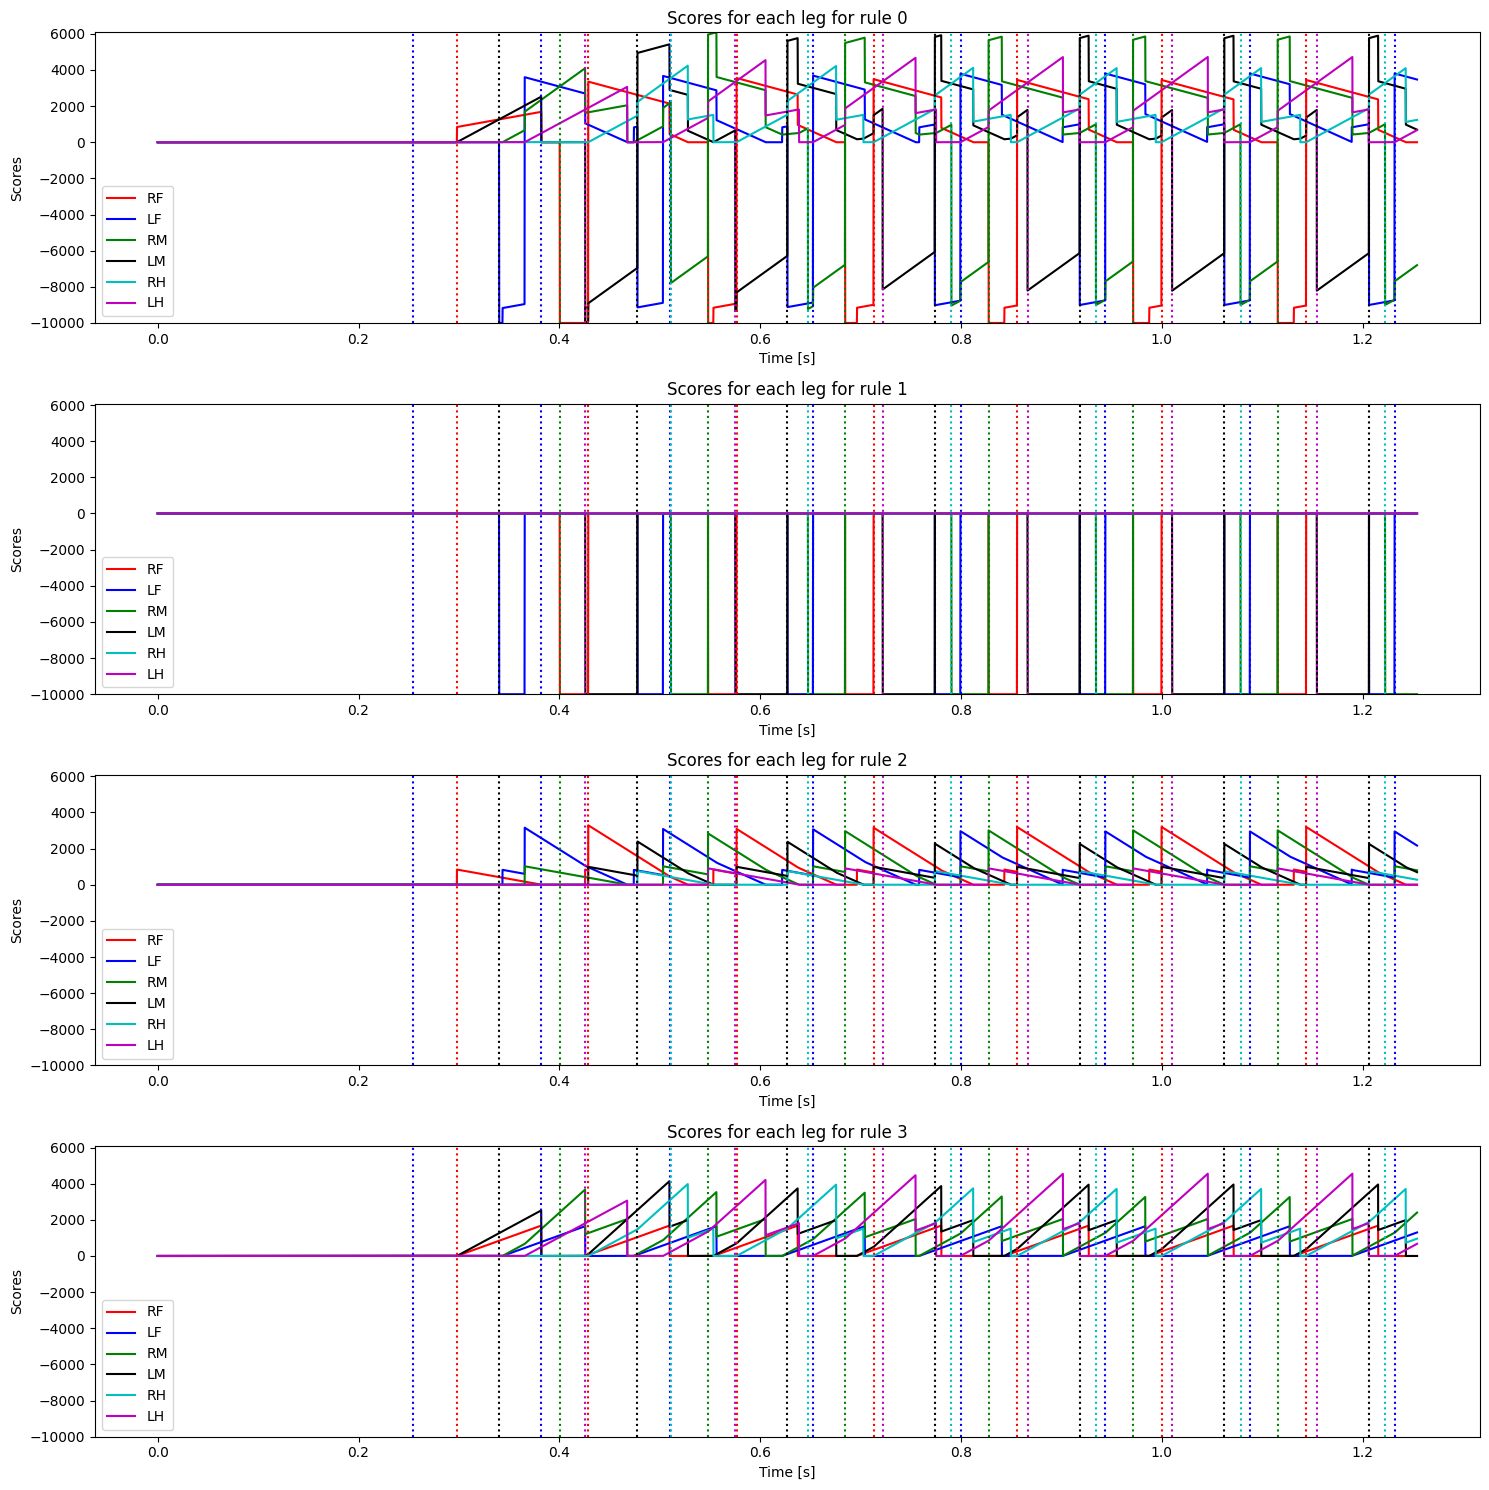

In [21]:
# Plot the evolution of the scores for each leg
fig, axs = plt.subplots(4, 1, figsize=(15, 15))

t_ids = np.arange(0, num_steps, 1)
time = t_ids*nmf.timestep

leg_of_interest = ["RF", "LF", "RM", "LM", "RH", "LH"]
colors = ["r", "b", "g", "k", "c", "m"]
j_ids = np.tile([legs.index(leg) for leg in leg_of_interest], (len(t_ids), 1)).T

for a, (ax, rule_score) in enumerate(zip(axs, [all_leg_scores[j_ids, t_ids], all_legs_rule1_scores, all_legs_rule2_scores, all_legs_rule3_scores])):
    for i, l_score in enumerate(rule_score[j_ids, t_ids]):
        if i ==0:
            ax.set_title("Scores for each leg")
        else:
            ax.set_title("Scores for each leg for rule "+str(a))
        ax.set_xlabel("Time [s]")
        ax.set_ylabel("Scores")

        ax.plot(time, l_score, c=colors[i], linestyle="-", label=leg_of_interest[i])
        ax.set_ylim([np.min(all_legs_rule1_scores), np.max(all_leg_scores)])
    
    for leg_id, step in all_initiated_legs:
        color_index = leg_of_interest.index(legs[leg_id])
        #print(color_index, step)
        ax.axvline(time[step], color=colors[color_index], linestyle=":")
    ax.legend()

fig.tight_layout()
plt.show()

Finally, we inspect the video:

In [22]:
from ipywidgets import Video
Video.from_file(out_dir / 'cruse_flat.mp4')

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free...')

## Plot gait diagram

The gait diagram is a common visualization when studying locomotion. It simplifies the visualization of coordination between legs. Stance timepoints are shown in black while swing timepoints are shown in white.

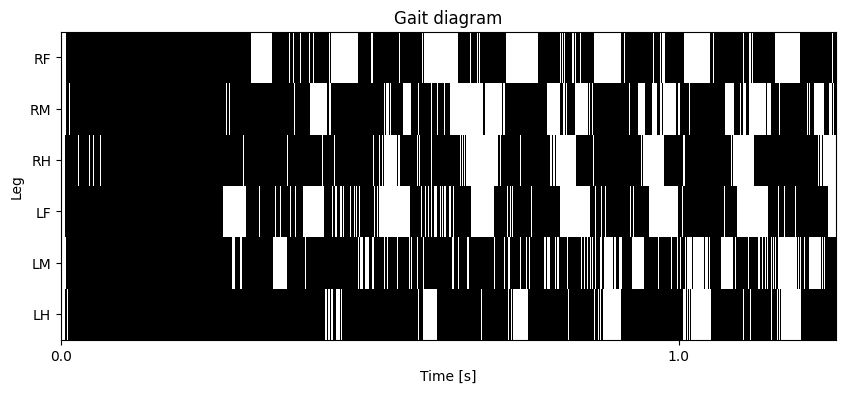

In [23]:
# plot the gait diagram

# Build an where lines are legs, columns are timepoint and there is a one in the array if the left leg is in contact with the ground
# and a zero if it is not
all_legs_contact = np.zeros((len(legs), num_steps))
gait_diagram_leg_order = ["RF", "RM", "RH", "LF", "LM", "LH"]

assert set(gait_diagram_leg_order) == set(legs)

for t in range(num_steps):
    for l, leg in enumerate(gait_diagram_leg_order):
        all_legs_contact[l, t] = np.sum(obs_list_cruse_flat[t]["contact_forces"][leg_force_sensors_ids[leg]]) > 0

# plot the gait diagram leg vs time should appear black if the leg is in contact with the ground
# median filter the contat to smooth the gait diagram

from scipy.signal import medfilt

plt.figure(figsize=(10, 4))
#all_legs_contact_smooth = medfilt(all_legs_contact, kernel_size=(1, 3))
plt.imshow((np.logical_not(all_legs_contact)), cmap="gray", aspect="auto", interpolation="none")
plt.xlabel("Time [s]")
plt.ylabel("Leg")
plt.yticks(np.arange(len(legs)), gait_diagram_leg_order)
plt.xticks(t_ids[::10000], time[::10000])
plt.title("Gait diagram")
plt.show()

The gait implemented by the fly with a random seed of 32 is not a classical gait used by the fly. It is very close to a crossed trot gait (Front and contralateral hindleg swinging together) used by some quadrupeds with some additional midleg movements.

The tripod gait is the canonical gait used by flies. It is the fastest and most stable gait the fly is using. You can learn more about it in [DeAngelis et al. (2019)](https://elifesciences.org/articles/46409#content) and [Ramdya et al. (2017)](https://www.nature.com/articles/ncomms14494). How would you need to modify the Cruse rules to get a tripod gait ?

# Compare with random controller

In [31]:
np.random.seed(100)
#Comparison with random is interesting but probability of stepping should be the same !!!!!!!!

p_step = (number_of_taken_steps)/(num_steps-n_stabilisation_steps)*1.01 # and then percent more probable to step

nmf.reset()
"""nmf = NeuroMechFlyMuJoCo(render_mode='saved',
                         output_dir=out_dir,
                         timestep=1e-4,
                         render_config={'playspeed': 0.1, 'camera':"Animat/camera_left"},
                         init_pose='stretch',
                         actuated_joints=leg_dofs_fused_tarsi,
                         physics_config=physics_config,
                         terrain_config=terrain_config)"""

stepping_advancement = np.zeros(len(legs)).astype(int)

obs_list_random_flat = []
n_step_random_taken = 0
n_late_steps = 0

#Run the actual simulation
for i in trange(num_steps):

    # Decide if going to step or not
    p = np.random.rand()
    if i > n_stabilisation_steps and p<p_step:
        #Decide in which leg to step if all legs are already stepping increment late step counter
        try:
            initiating_leg = np.random.choice(leg_ids[stepping_advancement <= 0])
            n_step_random_taken += 1
            stepping_advancement[initiating_leg] += 1
        except:
            n_late_steps += 1
    
    if n_late_steps > 0 and np.any(stepping_advancement <= 0):
        # If some step could not have been perfomed previously, we an perfom them as soon as the steppinf advancement is zero
        initiating_leg = np.random.choice(leg_ids[stepping_advancement <= 0])
        n_step_random_taken += 1
        stepping_advancement[initiating_leg] += 1
        n_late_steps -= 1

    
    joint_pos = step_data_block_manualcorrect[joint_ids, stepping_advancement[match_leg_to_joints]]
    action = {'joints': joint_pos}
    obs, info = nmf.step(action)
    nmf.render()
    obs_list_random_flat.append(obs)

    #Compute score and update stepping advancement
    leg_scores = np.zeros(len(legs))
    for k, leg in enumerate(legs):
        #Update_the_stepping_advancement
        if stepping_advancement[k] >= interp_step_duration-1:
            stepping_advancement[k] = 0
        elif stepping_advancement[k] > 0:
            stepping_advancement[k] +=1
        
    all_leg_scores[:, i] = leg_scores

distances = obs_list_random_flat[n_stabilisation_steps]["fly"][0][:2] - obs_list_random_flat[-1]["fly"][0][:2]
print("Forward distance travelled: ", distances[0])
print("Lateral distance travelled: ", distances[1])   

print("Target number of steps: ", number_of_taken_steps, "\n"
      "Number of steps taken by random: ", n_step_random_taken)

nmf.save_video(out_dir / 'random_flat.mp4')
#nmf.close()

100%|██████████| 12543/12543 [00:20<00:00, 601.06it/s]


Forward distance travelled:  -421.57677579177886
Lateral distance travelled:  -897.3241613698816
Target number of steps:  80 
Number of steps taken by random:  48


Note that in most cases (not this one) the random controller is not terrible, an animal with 6 legs is very stable on flat terrain. If ye would compare the energy expenditure the random controller would perform worse than the Cruse controller.

In [32]:
Video.from_file(out_dir / 'random_flat.mp4')

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free...')

# Try on complex terrain

In [26]:
np.random.seed(42)

# input that in different notebook
nmf_gapped = NeuroMechFlyMuJoCo(render_mode='saved',
                         terrain = "gapped",
                         output_dir=out_dir,
                         timestep=1e-4,
                         render_config={'playspeed': 0.1, 'camera':"Animat/camera_left"},
                         init_pose='stretch',
                         actuated_joints=leg_dofs_fused_tarsi,
                         physics_config=physics_config,
                         terrain_config=terrain_config)

# This serves to keep track of the advancement of each leg in the stepping sequence
stepping_advancement = np.zeros(len(legs)).astype(int)

# This represents the score of each leg in the current step
leg_scores = np.zeros(len(legs))
all_leg_scores = np.zeros((len(legs), num_steps))

all_legs_rule1_scores = np.zeros((len(legs), num_steps))
all_legs_rule2_scores = np.zeros((len(legs), num_steps))
all_legs_rule3_scores = np.zeros((len(legs), num_steps))

# one percent margin if leg score within this margin to the max score random choice between the very likely legs
percent_margin = 0.001

obs_list_cruse_gapped = []
all_initiated_legs = []

#Run the actual simulation
for i in trange(num_steps):

    #Decide in which leg to step
    initiating_leg = np.argmax(leg_scores)
    within_margin_legs = leg_scores[initiating_leg]-leg_scores <= leg_scores[initiating_leg]*percent_margin

    # If multiple legs are within the margin choose randomly among those legs
    if np.sum(within_margin_legs) > 1:
        initiating_leg = np.random.choice(np.where(within_margin_legs)[0])

    # If the maximal score is zero or less (except for the first step after stabilisation to initate the locomotion) or if the leg is already stepping
    if (leg_scores[initiating_leg] <= 0 and not i == n_stabilisation_steps+1) or stepping_advancement[initiating_leg] > 0:
        initiating_leg = None
    else:
        stepping_advancement[initiating_leg] += 1
        all_initiated_legs.append([initiating_leg, i])
        number_of_taken_steps += 1
    
    joint_pos = step_data_block_manualcorrect[joint_ids, stepping_advancement[match_leg_to_joints]]
    action = {'joints': joint_pos}
    obs, info = nmf.step(action)
    nmf.render()
    obs_list_cruse_gapped.append(obs)

    stepping_advancement = update_stepping_advancement(stepping_advancement, legs, interp_step_duration)

    leg_scores = compute_leg_scores(rule1_corresponding_legs, rule1_weight,
                                    rule2_corresponding_legs, rule2_weight, rule2_weight_contralateral,
                                    rule3_corresponding_legs, rule3_weight, rule3_weight_contralateral,
                                    stepping_advancement, leg_corresp_id, leg_stance_starts, interp_step_duration)
        
    all_leg_scores[:, i] = leg_scores

nmf.save_video(out_dir / 'cruse_gapped.mp4')
nmf.close()

distances = obs_list_cruse_gapped[n_stabilisation_steps]["fly"][0][:2] - obs_list_cruse_gapped[-1]["fly"][0][:2]
print("Forward distance travelled: ", distances[0])
print("Lateral distance travelled: ", distances[1])

100%|██████████| 12543/12543 [00:21<00:00, 584.99it/s]


Forward distance travelled:  -4161.610134769665
Lateral distance travelled:  848.7426656196332


In [27]:
Video.from_file(out_dir / 'cruse_gapped.mp4')

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free...')

Here this approach is failling. There are multiple reasons for this. In this implementation the stepping probability does not depend on the situation. Swing and stance are duration are hard coded and not flexible. One of the most important rule to guaranty stability using the Cruse rules is the first rule. When a leg is in swing the neighbours can not swing. Here when the leg falls in a hole the neighbouring legs could escape inhibition if the swing counter comes to an end. Luckily such rule could be implemented as we have acces to the force feedback.

In addition to those three first rules we will implement rule 5 also based on force feedback to make the gait more reliable

- Rule 1: When in swing other legs are inhibitted (Time without contact forces)
- Rule 2: When early in stance encourage (Early stance could be phase of increasing load), or touchdown only
- Rule 3: when late in stacne force swing (late stance could be phjase of decreasing load)
- Rule 5: Distribute the weight; If the weight increases in one leg prolong the stance in the other legs

# Define Cruse rules in term of contact force feedback

## Compute the contact forces from the previous simulation

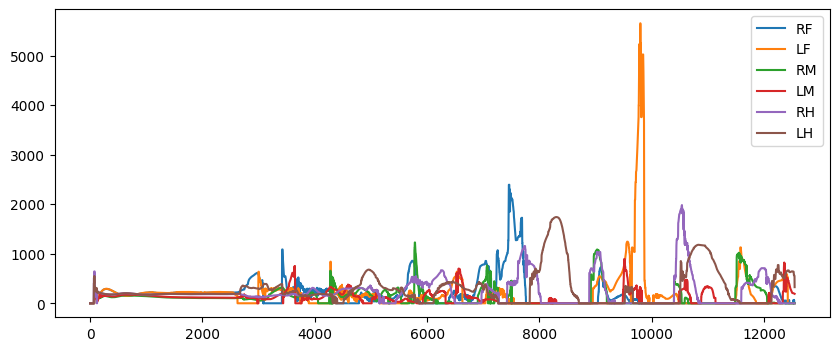

In [28]:
# Lets test the rules on the contact forces from the previous simulation

all_legs_contact_forces = []

for obs in obs_list_cruse_gapped:
    all_legs_contact_forces.append([np.sum(obs["contact_forces"][leg_force_sensors_ids[leg]]) for leg in legs])

# Median filter the contact forces as the readout can be very noisy
all_legs_contact_forces = medfilt(all_legs_contact_forces, kernel_size=(21, 1))

plt.figure(figsize=(10, 4))
plt.plot(all_legs_contact_forces, label = legs)
plt.legend()
plt.show()


## Proposition of activation rules

In [29]:
def activate_rule1(leg_contact_forces, i, window_size=20):
     # Activated if the leg is in swing for a couple of steps
    if i < window_size:
         window_size = i
    return np.all(leg_contact_forces[i-window_size:i] <= 0)

def activate_rule2(leg_contact_forces, i, leg_touchdown_counter, touchdown_duration=100, window_size=10):
    # This rule is active if the contact force was zero for a couple of steps and then it increases
    # The duration of this effect is fixed by the touchdown_duration

    if i < window_size:
         window_size = i

    if leg_touchdown_counter == touchdown_duration:
            leg_touchdown_counter = 0
    
    if leg_touchdown_counter <= 0 and leg_contact_forces[i] > 0 and np.all(leg_contact_forces[i-window_size:i-1] <= 0): # add stepping advancement > 0
        leg_touchdown_counter += 1
        return True, leg_touchdown_counter
    
    if leg_touchdown_counter > 0:
        leg_touchdown_counter += 1
        return True, leg_touchdown_counter
    else:
        return False, leg_touchdown_counter

def rule3_contribution(leg_contact_forces, i, leg_last_max_stance_force, time_since_last_max_stance, window_size=20):
    #This function returns the contribution of the rule 3 to the leg score
    #The contribution increases as the contact force decreases (i.e the leg is comming closer to the end of the stance)
    #If the contact force goes up again, the contribution is reset to zero
    #If the leg is in stance again for a couple of steps, the contribution is reset to zero
    # The contribution is the difference between the last max stance force and the current contact force last max stance force should be the max contact force during the stance

    contribution = 0
    if i < window_size:
         window_size = i

    # if the counter was ON and the leg is in swing or the load is increasing again, reset the counter (return 0, 0, 0)
    if (np.all(leg_contact_forces[i-window_size:i] <= 0) or np.median(np.diff(leg_contact_forces[i-window_size:i])) > 0 and time_since_last_max_stance > 0):
            return contribution, 0, 0
    # if the contact force is deceasing 
    if  np.median(np.diff(leg_contact_forces[i-window_size:i])) < 0 and time_since_last_max_stance <= 0: # add stepping advancement > 0
        leg_last_max_stance_force = leg_contact_forces[i]
        contribution = leg_last_max_stance_force - leg_contact_forces[i]
    
    if leg_last_max_stance_force > 0:
        contribution = leg_last_max_stance_force - leg_contact_forces[i]
        return contribution if contribution > 0 else 0, leg_last_max_stance_force, time_since_last_max_stance + 1
    else:
        return contribution, 0, 0
    
    
def rule4_decrease_increase_timestep(leg_contact_forces, i, counter_since_last_increase, prev_output, min_decrease_interval=50, window_size=10):
    #This function send a 1 if the step size should be decreases it returns -1 if the step size can be increased again
    #The function waits for a couple of steps before seding the signal to decrease the step size again

    step_size_action = 0
    if i < window_size:
        window_size = i

    if counter_since_last_increase < min_decrease_interval:
        counter_since_last_increase += 1
    else:
        counter_since_last_increase = 0
        if np.median(np.diff(leg_contact_forces[i-window_size:i])) < 1 and  prev_output == 1:
            step_size_action = -1

    if np.median(np.diff(leg_contact_forces[i-window_size:i])) > 1 and  counter_since_last_increase == 0:
        step_size_action = 1
        counter_since_last_increase += 1
    
    return step_size_action, counter_since_last_increase


## Test the rules on previous simulation

/Users/stimpfli/miniconda3/envs/flygym/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/stimpfli/miniconda3/envs/flygym/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


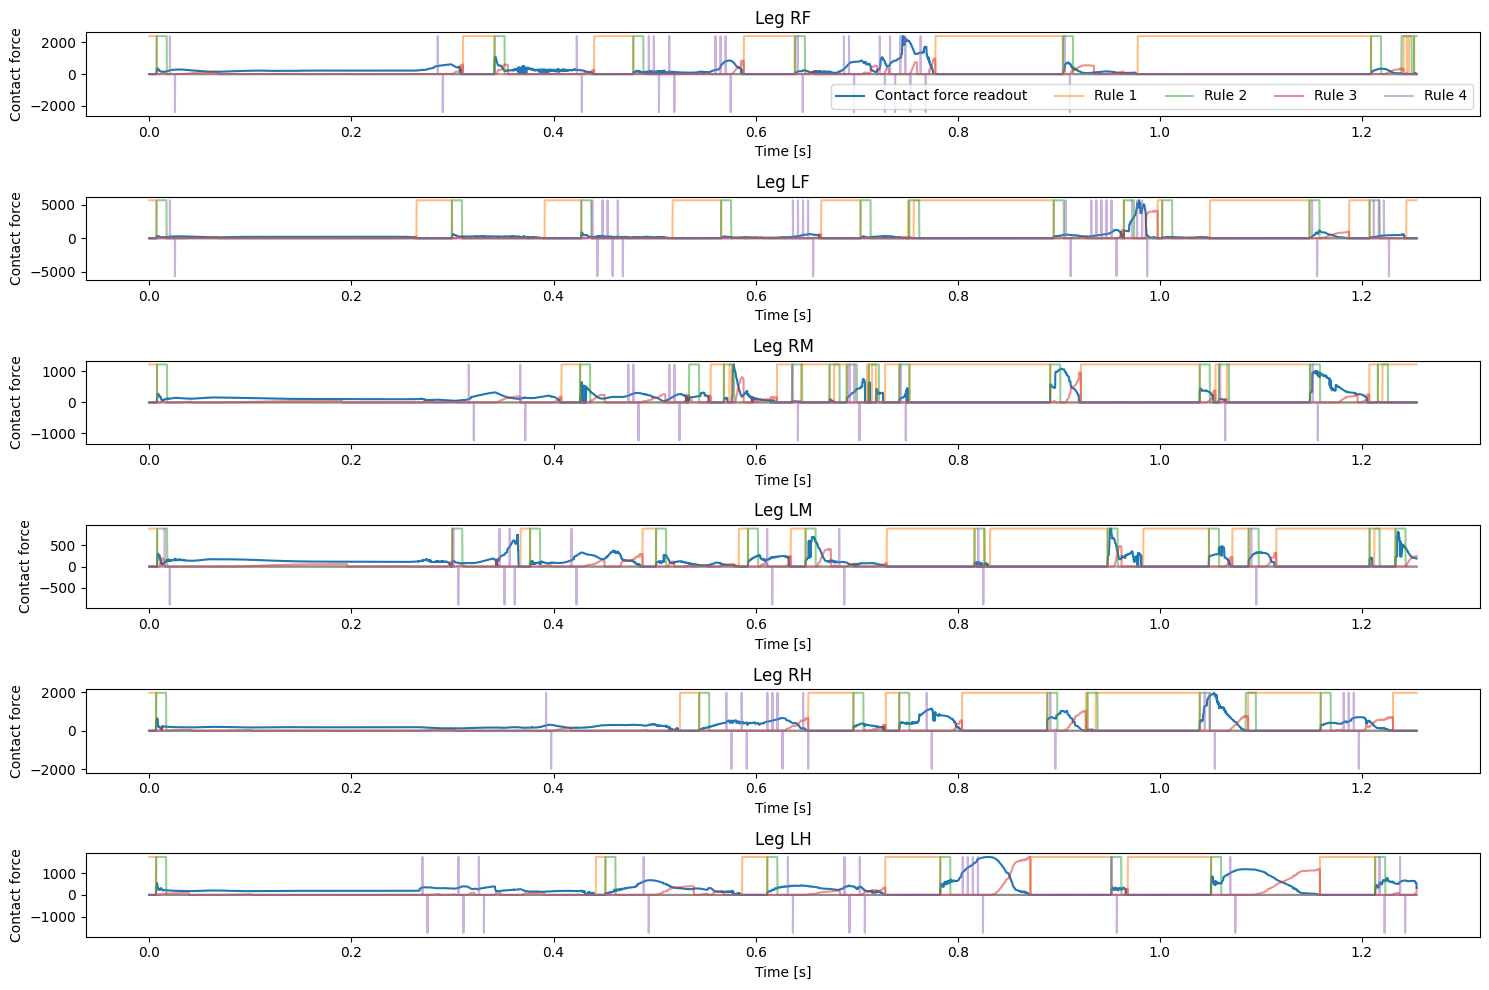

In [30]:
time = np.arange(0, num_steps, 1)*nmf.timestep

rule1_isactive_legs = np.zeros((len(legs), num_steps))

rule2_isactive_legs = np.zeros((len(legs), num_steps))
leg_touchdown_counter = np.zeros(len(legs))

rule3_contributions_legs = np.zeros((len(legs), num_steps))
leg_last_max_stance_force = np.zeros(len(legs))
time_since_last_max_stance = np.zeros(len(legs)) 

rule4_step_size_action = np.zeros((len(legs), num_steps))
counter_since_last_increase = np.zeros(len(legs))
legs_prev_step_size_action = np.zeros(len(legs))

for i in range(num_steps):
    for l, leg in enumerate(legs):
        rule1_isactive_legs[l, i] = activate_rule1(all_legs_contact_forces[:, l], i)
        rule2_isactive_legs[l, i], leg_touchdown_counter[l] = activate_rule2(all_legs_contact_forces[:, l], i, leg_touchdown_counter[l])
        rule3_contributions_legs[l, i], leg_last_max_stance_force[l], time_since_last_max_stance[l] = rule3_contribution(all_legs_contact_forces[:, l],
                                                                                                              i, leg_last_max_stance_force[l], time_since_last_max_stance[l])
        rule4_step_size_action[l, i], counter_since_last_increase[l] = rule4_decrease_increase_timestep(all_legs_contact_forces[:, l], i, counter_since_last_increase[l], legs_prev_step_size_action[l])
        legs_prev_step_size_action[l] = rule4_step_size_action[l, i] if not rule4_step_size_action[l, i] == 0 else legs_prev_step_size_action[l]

# Plot the contact force and the the rule conditions
fig, axs = plt.subplots(len(legs), 1, figsize=(15, 10))
for l, leg in enumerate(legs):
    axs[l].plot(time, all_legs_contact_forces[:, l], label = f"Contact force readout")
    visu_scaling = np.max(all_legs_contact_forces[:, l])
    axs[l].plot(time, rule1_isactive_legs[l, :]*visu_scaling, label = "Rule 1", alpha =0.5)
    axs[l].plot(time, rule2_isactive_legs[l, :]*visu_scaling, label = "Rule 2", alpha =0.5)
    axs[l].plot(time, rule3_contributions_legs[l, :]*1, label = "Rule 3", alpha =0.5)
    axs[l].plot(time, rule4_step_size_action[l, :]*visu_scaling, label = "Rule 4", alpha =0.5)
    if l == 0:
        axs[l].legend(loc = "lower right", ncol=5)
    axs[l].set_xlabel("Time [s]")
    axs[l].set_ylabel("Contact force")
    axs[l].set_title(f"Leg {leg}")

fig.tight_layout()

Given those simple implementations of the cruse rules based on force feedback can you combine them to get a complex-terrain-proof controller. Feel free to modify those functions and come up with new rules.


Those functions are not taking into account the stepping advancement. Introducing this variable might make the usage of rules even more robust.


Tips:
- Increasing the stance duration could be performed by incrementing the stepping adavancement only by a fraction. Reading form the joint angles could be done using the np.round function. A cleaner way of doing that could be to interpolate between points in the joint angles.
- Visualize both the gait and the evolution of the score. What leg should be stepping? Why is it not? Implement rules encouraging the desired stepping. 
- Reducing the number of degrees of freedom for the step might be usefull feel free to engineer your own (simpler and probably unrealistic) stepping function
